### COGS118B Final Project Source Code
#### -Eigenspace-Based Action Recognition: Applying PCA Classification to CLIP Image Embeddings-


### 1. Dataset: Stanford 40 Actions: organize the images into different action folders

In [1]:
import os
import shutil
from collections import defaultdict

In [2]:
# Path to the JPEGImages folder
source_folder = "./JPEGImages"

In [3]:
# Retrieve all jpg files
all_images = [f for f in os.listdir(source_folder) if f.endswith('.jpg')]

print(f"Found {len(all_images)} total images")

# Group images by action name
action_groups = defaultdict(list)

for image_file in all_images:
    # Remove .jpg extension
    name_without_ext = image_file.replace('.jpg', '')
    
    # Split by underscore and get action name (everything except last part which is the number)
    parts = name_without_ext.split('_')
    action = '_'.join(parts[:-1])  # Everything except the number
    
    action_groups[action].append(image_file)

# Print what we found
print(f"\nFound {len(action_groups)} unique actions:")
for action, images in sorted(action_groups.items()):
    print(f"  {action}: {len(images)} images")

# Create action folders and move images
print("\nOrganizing images into folders...")

for action, images in action_groups.items():
    # Create action folder
    action_folder = os.path.join(source_folder, action)
    os.makedirs(action_folder, exist_ok=True)
    
    # Move images into the folder
    for image_file in images:
        src = os.path.join(source_folder, image_file)
        dst = os.path.join(action_folder, image_file)
        
        # Only move if source exists and is a file (not already moved)
        if os.path.isfile(src):
            shutil.move(src, dst)
    
    print(f"  ✓ {action}: {len(images)} images moved")

print("\n✓ Organization complete!")

# Verify the structure
print("\nFinal folder structure:")
for action in sorted(action_groups.keys()):
    action_folder = os.path.join(source_folder, action)
    count = len([f for f in os.listdir(action_folder) if f.endswith('.jpg')])
    print(f"  {action}/: {count} images")

Found 0 total images

Found 0 unique actions:

Organizing images into folders...

✓ Organization complete!

Final folder structure:


### 2. Extract CLIP Embeddings

In [4]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import pickle

In [5]:
print("EXTRACTING CLIP EMBEDDINGS")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n Using device: {device}")

EXTRACTING CLIP EMBEDDINGS

 Using device: cuda


In [6]:
# Load CLIP Model -- Using the started code provided
try:
    from transformers import CLIPModel, CLIPProcessor
    
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    model = model.to(device)
    model.eval()
    
    print(f"✓ CLIP model loaded successfully!")
    print(f"  Embedding dimension: 512")
    
except Exception as e:
    print(f"Error loading CLIP: {e}")
    print("Trying alternative approach...")
    
    # Alternative: use clip-vit-large-patch14 which is more stable
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
    model = model.to(device)
    model.eval()
    
    print(f"✓ CLIP model loaded (large variant)!")

2025-12-10 21:40:11.156801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-10 21:40:11.156847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-10 21:40:11.158452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-10 21:40:11.166581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✓ CLIP model loaded successfully!
  Embedding dimension: 512


In [7]:
# Select actions and load paths
SELECTED_ACTIONS = ['applauding', 'cooking', 'blowing_bubbles']
print(f"\n Selected actions: {SELECTED_ACTIONS}")

IMAGES_PATH = "JPEGImages"
action_image_paths = {}

for action in SELECTED_ACTIONS:
    action_dir = os.path.join(IMAGES_PATH, action)
    image_files = [f for f in os.listdir(action_dir) if f.endswith('.jpg')]
    full_paths = [os.path.join(action_dir, f) for f in image_files]
    action_image_paths[action] = full_paths
    print(f"  {action}: {len(full_paths)} images")



 Selected actions: ['applauding', 'cooking', 'blowing_bubbles']
  applauding: 266 images
  cooking: 77 images
  blowing_bubbles: 162 images


In [8]:
# Extract embeddings function


def embed_images(image_paths, batch_size=16):
    """Extract CLIP embeddings."""
    embeddings = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting", leave=False):
        batch_paths = image_paths[i:i + batch_size]
        
        # Load images
        images = []
        for path in batch_paths:
            try:
                img = Image.open(path).convert("RGB")
                images.append(img)
            except Exception as e:
                continue
        
        if len(images) == 0:
            continue
        
        try:
            # Process with CLIP
            inputs = processor(images=images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
  # Extract embeddings
            with torch.no_grad():
                outputs = model.get_image_features(**inputs)
                # Normalize
                outputs = outputs / outputs.norm(dim=-1, keepdim=True)
            
            embeddings.append(outputs.cpu().numpy())
        
        except Exception as e:
            print(f"Error processing batch: {e}")
            continue
    
    return np.vstack(embeddings) if embeddings else np.array([])

In [9]:
# Extract embeddings for each action

print(f"\n Extracting embeddings (this may take 2-5 minutes)...")
all_embeddings = {}
all_labels = {}

for action in SELECTED_ACTIONS:
    print(f"\n Processing '{action}'...")
    embeddings = embed_images(action_image_paths[action], batch_size=16)
    all_embeddings[action] = embeddings
    all_labels[action] = np.array([action] * len(embeddings))
    print(f"  ✓ {embeddings.shape[0]} embeddings extracted, dim={embeddings.shape[1]}")

# Create train/test split
from sklearn.model_selection import train_test_split

X_all = np.vstack([all_embeddings[action] for action in SELECTED_ACTIONS])
y_all = np.concatenate([all_labels[action] for action in SELECTED_ACTIONS])

print(f"\n Total: {len(X_all)} samples, {X_all.shape[1]}-D embeddings")

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)

print(f"  Train: {len(X_train)} samples")
print(f"  Test: {len(X_test)} samples")
# Save embeddings
os.makedirs("embeddings", exist_ok=True)
data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'action_classes': SELECTED_ACTIONS,
    'embedding_dim': X_train.shape[1]
}



 Extracting embeddings (this may take 2-5 minutes)...

 Processing 'applauding'...


Extracting:   0%|          | 0/17 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

  ✓ 266 embeddings extracted, dim=512

 Processing 'cooking'...


  ✓ 77 embeddings extracted, dim=512

 Processing 'blowing_bubbles'...


  ✓ 162 embeddings extracted, dim=512

 Total: 505 samples, 512-D embeddings
  Train: 353 samples
  Test: 152 samples


In [10]:
with open('embeddings/stanford40_clip_embeddings.pkl', 'wb') as f:
    pickle.dump(data, f)

print(f"\nCOMPLETE!")
print(f"Saved to: embeddings/stanford40_clip_embeddings.pkl")


COMPLETE!
Saved to: embeddings/stanford40_clip_embeddings.pkl


### 3. PCA Analysis & Visualization

In [11]:
# Finding patterns/structure in the 768-D embeddings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [12]:
# Load Embeddings
print("\n Loading embeddings...")

with open('embeddings/stanford40_clip_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
SELECTED_ACTIONS = data['action_classes']

print(f"✓ Loaded:")
print(f"  Train: {len(X_train)} samples")
print(f"  Test: {len(X_test)} samples")
print(f"  Embedding dim: {X_train.shape[1]}")
print(f"  Actions: {SELECTED_ACTIONS}")


 Loading embeddings...
✓ Loaded:
  Train: 353 samples
  Test: 152 samples
  Embedding dim: 512
  Actions: ['applauding', 'cooking', 'blowing_bubbles']


In [13]:
# Apply PCA to find structure
print(f"\n Applying PCA to training data...")

# Fit PCA on all components
pca_full = PCA()
pca_full.fit(X_train)

# Get variance explained
explained_var = pca_full.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var)

print(f"\n Variance Explained by Components:")
for threshold in [0.90, 0.95, 0.99]:
    n_components = np.argmax(cumsum_var >= threshold) + 1
    print(f"  {threshold*100:.0f}% variance: {n_components} components")


 Applying PCA to training data...

 Variance Explained by Components:
  90% variance: 121 components
  95% variance: 165 components
  99% variance: 249 components



 Creating variance plots...


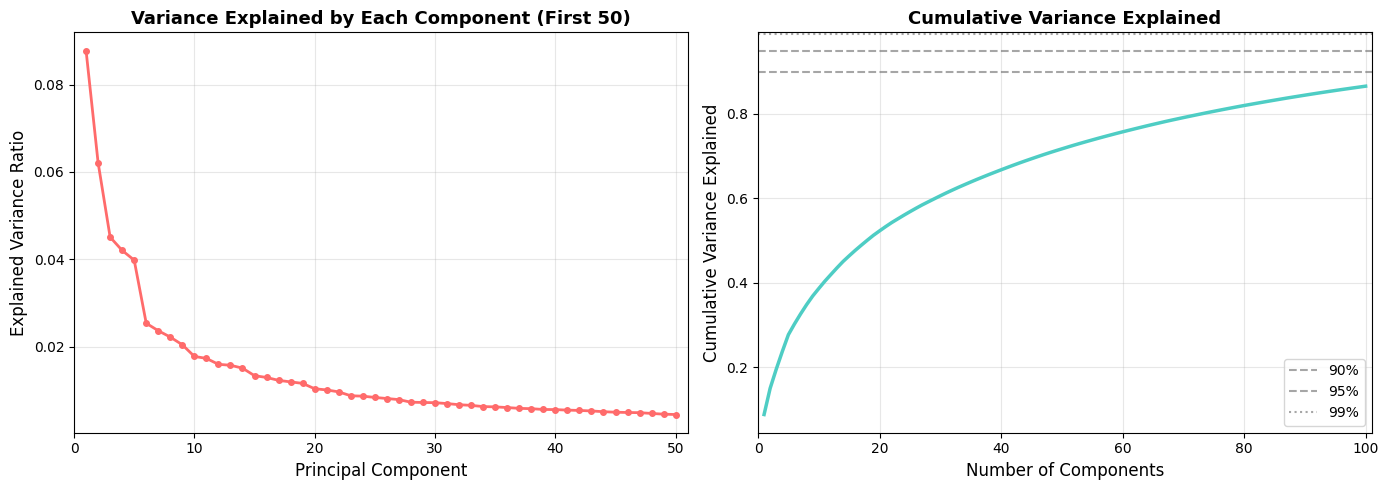

✓ Saved: results/explained_variance.png


In [14]:
# Visualize explained variance
print(f"\n Creating variance plots...")

# Create results directory
os.makedirs("results", exist_ok=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Variance per component (first 50)
ax1.plot(range(1, 51), explained_var[:50], 'o-', linewidth=2, markersize=4, color='#FF6B6B')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('Variance Explained by Each Component (First 50)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 51)
# Plot 2: Cumulative variance
ax2.plot(range(1, 101), cumsum_var[:100], linewidth=2.5, color='#4ECDC4')
ax2.axhline(y=0.90, color='gray', linestyle='--', alpha=0.7, label='90%')
ax2.axhline(y=0.95, color='gray', linestyle='--', alpha=0.7, label='95%')
ax2.axhline(y=0.99, color='gray', linestyle=':', alpha=0.7, label='99%')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained', fontsize=12)
ax2.set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 101)

plt.tight_layout()
plt.savefig('results/explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/explained_variance.png")


 Creating 2D PCA projection...


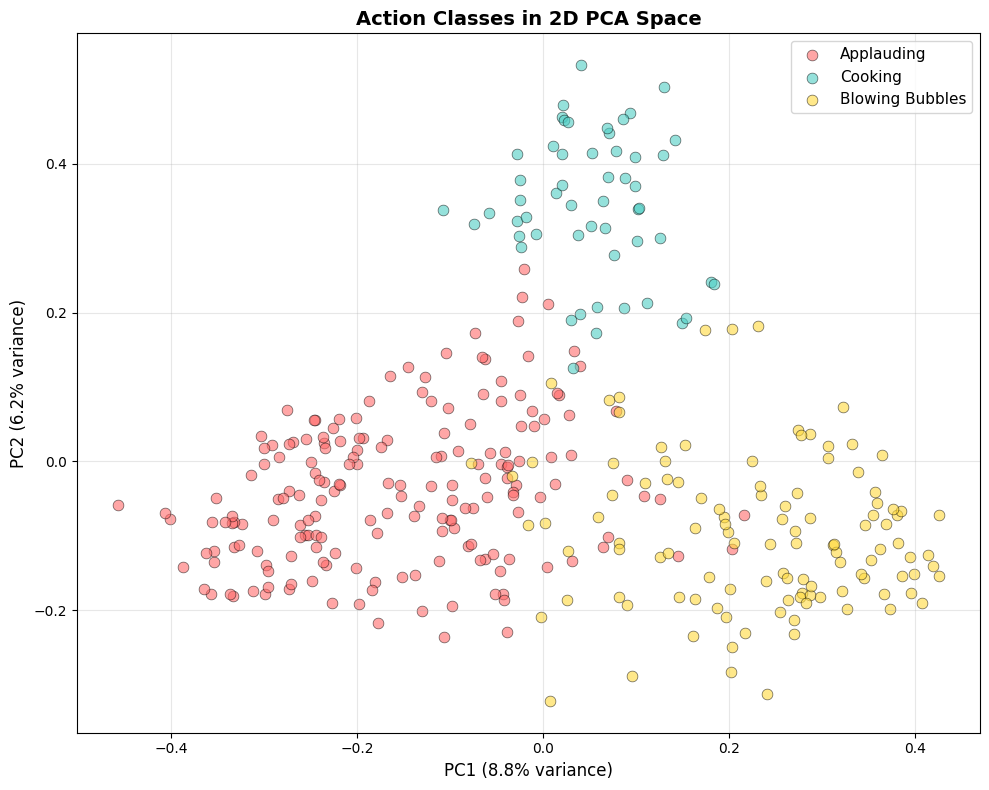

✓ Saved: results/pca_2d_visualization.png


In [15]:
# 2D Viz
print(f"\n Creating 2D PCA projection...")

pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train)

# Nice colors for each action
colors = ['#FF6B6B', '#4ECDC4', '#FFD93D']

plt.figure(figsize=(10, 8))
for i, action in enumerate(SELECTED_ACTIONS):
    mask = y_train == action
    plt.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], 
                c=colors[i], label=action.replace('_', ' ').title(), 
                alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

var1 = pca_2d.explained_variance_ratio_[0] * 100
var2 = pca_2d.explained_variance_ratio_[1] * 100
plt.xlabel(f'PC1 ({var1:.1f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({var2:.1f}% variance)', fontsize=12)
plt.title('Action Classes in 2D PCA Space', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/pca_2d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/pca_2d_visualization.png")


 Creating 3D PCA projection...


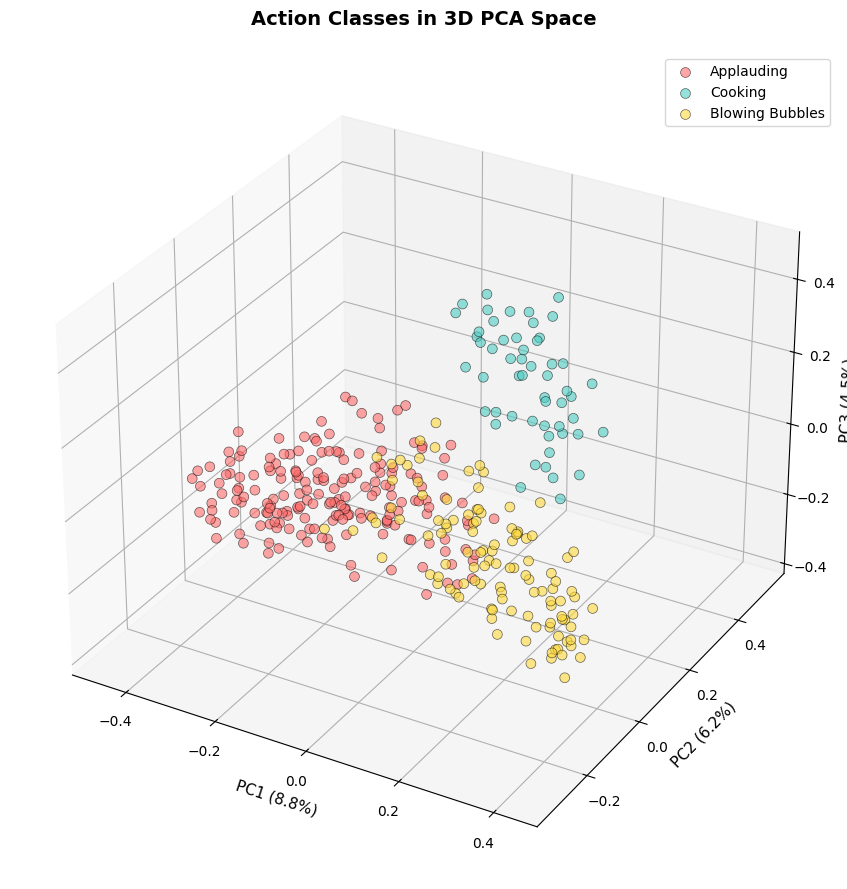

✓ Saved: results/pca_3d_visualization.png


In [16]:
# 3D Viz
print(f"\n Creating 3D PCA projection...")

pca_3d = PCA(n_components=3)
X_train_3d = pca_3d.fit_transform(X_train)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for i, action in enumerate(SELECTED_ACTIONS):
    mask = y_train == action
    ax.scatter(X_train_3d[mask, 0], X_train_3d[mask, 1], X_train_3d[mask, 2],
               c=colors[i], label=action.replace('_', ' ').title(), 
               alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

var1 = pca_3d.explained_variance_ratio_[0] * 100
var2 = pca_3d.explained_variance_ratio_[1] * 100
var3 = pca_3d.explained_variance_ratio_[2] * 100
ax.set_xlabel(f'PC1 ({var1:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({var2:.1f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({var3:.1f}%)', fontsize=11)
ax.set_title('Action Classes in 3D PCA Space', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('results/pca_3d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/pca_3d_visualization.png")

In [17]:
# Summary
print("PCA Analysis COMPLETE!")
print(f"\nKey Findings:")
print(f"  • Original dimensionality: {X_train.shape[1]}")
print(f"  • 90% variance captured by: {np.argmax(cumsum_var >= 0.90) + 1} components")
print(f"  • 95% variance captured by: {np.argmax(cumsum_var >= 0.95) + 1} components")
print(f"  • First 2 PCs explain: {(var1 + var2):.1f}% of variance")
print(f"  • First 3 PCs explain: {(var1 + var2 + var3):.1f}% of variance")
print(f"\n Visualizations saved in results/ folder")

PCA Analysis COMPLETE!

Key Findings:
  • Original dimensionality: 512
  • 90% variance captured by: 121 components
  • 95% variance captured by: 165 components
  • First 2 PCs explain: 15.0% of variance
  • First 3 PCs explain: 19.5% of variance

 Visualizations saved in results/ folder


### 4. PCA-Based Classification

In [18]:
# Classify using reconstruction error (eigenfaces approach)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [19]:
# PCA Classification Function
def pca_classifier(X_train, y_train, X_test, y_test, n_components=50):
    """
    PCA-based classification using reconstruction error.
    
    Training: For each class, fit a separate PCA model
    Testing: Reconstruct test sample with each class's PCA,
             classify as class with minimum reconstruction error
    """
    classes = np.unique(y_train)
    pca_models = {}
    class_means = {}
    
    # Train: fit PCA for each class
    print(f"\n Training with {n_components} components...")
    for cls in classes:
        mask = y_train == cls
        X_class = X_train[mask]
        
        # Store mean and fit PCA
        class_means[cls] = X_class.mean(axis=0)
        pca = PCA(n_components=n_components)
        pca.fit(X_class - class_means[cls])
        pca_models[cls] = pca
        
        var_explained = pca.explained_variance_ratio_.sum() * 100
        print(f"  {cls}: {X_class.shape[0]} samples, {var_explained:.1f}% variance captured")
    
    # Test: classify by reconstruction error
    print(f"\n Testing on {len(X_test)} samples...")
    y_pred = []
    reconstruction_errors = {cls: [] for cls in classes}
    
    for x in tqdm(X_test, desc="Classifying", leave=False):
        errors = {}
        
        for cls in classes:
            # Center the sample
            x_centered = x - class_means[cls]
            
            # Project to PC space and reconstruct
            x_transformed = pca_models[cls].transform(x_centered.reshape(1, -1))
            x_reconstructed = pca_models[cls].inverse_transform(x_transformed)
            
            # Calculate reconstruction error (L2 distance)
            error = np.linalg.norm(x_centered - x_reconstructed)
            errors[cls] = error
        
        # Classify as class with minimum error
        predicted_class = min(errors, key=errors.get)
        y_pred.append(predicted_class)
    
    return np.array(y_pred)

In [21]:
# Test Different Numbers of Components
print("\n Testing different numbers of components...")
component_values = [10, 20, 50] 
results = []

for n_comp in component_values:
    print(f"\n{'='*50}")
    print(f"Testing with {n_comp} components")
    print('='*50)
    
    y_pred = pca_classifier(X_train, y_train, X_test, y_test, n_components=n_comp)
    acc = accuracy_score(y_test, y_pred)
    results.append((n_comp, acc))
    
    print(f"\n✓ Accuracy: {acc*100:.2f}%")


 Testing different numbers of components...

Testing with 10 components

 Training with 10 components...
  applauding: 186 samples, 37.1% variance captured
  blowing_bubbles: 113 samples, 45.2% variance captured
  cooking: 54 samples, 55.4% variance captured

 Testing on 152 samples...



✓ Accuracy: 98.03%

Testing with 20 components

 Training with 20 components...
  applauding: 186 samples, 52.4% variance captured
  blowing_bubbles: 113 samples, 62.1% variance captured
  cooking: 54 samples, 75.3% variance captured

 Testing on 152 samples...



✓ Accuracy: 94.74%

Testing with 50 components

 Training with 50 components...


  applauding: 186 samples, 75.8% variance captured
  blowing_bubbles: 113 samples, 86.1% variance captured
  cooking: 54 samples, 99.2% variance captured

 Testing on 152 samples...



✓ Accuracy: 94.74%



 Creating accuracy vs. components plot...


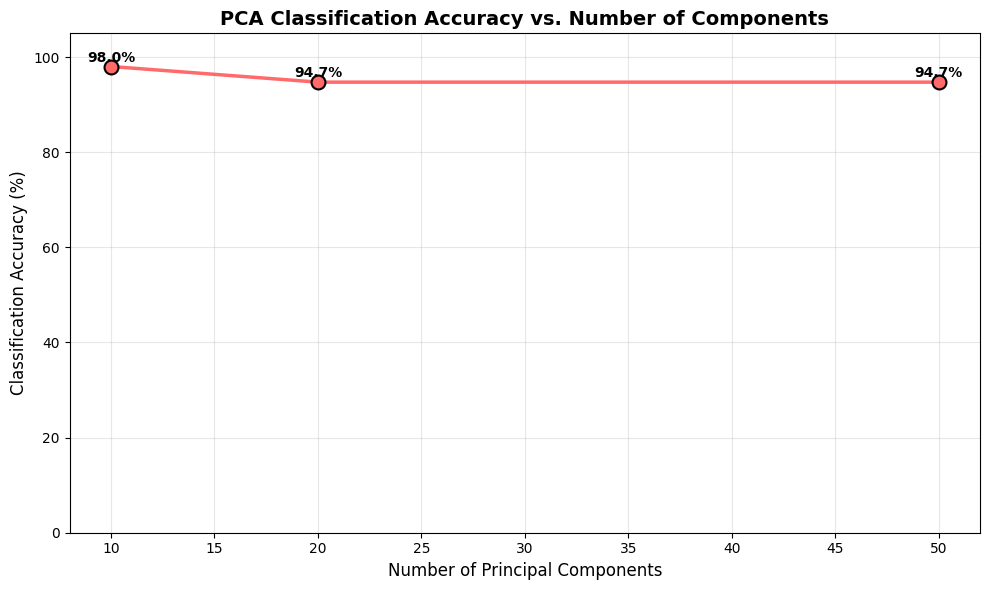

✓ Saved: results/accuracy_vs_components.png


In [22]:
# Plot Accuracy vs Components
print(f"\n Creating accuracy vs. components plot...")

plt.figure(figsize=(10, 6))
components, accuracies = zip(*results)
plt.plot(components, [a*100 for a in accuracies], 'o-', linewidth=2.5, 
         markersize=10, color='#FF6B6B', markeredgecolor='black', markeredgewidth=1.5)

for comp, acc in zip(components, accuracies):
    plt.text(comp, acc*100 + 1, f'{acc*100:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Classification Accuracy (%)', fontsize=12)
plt.title('PCA Classification Accuracy vs. Number of Components', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([0, 105])
plt.tight_layout()
plt.savefig('results/accuracy_vs_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/accuracy_vs_components.png")

In [23]:
# Final Evaluation with Best Components
best_n_comp = max(results, key=lambda x: x[1])[0]
best_acc = max(results, key=lambda x: x[1])[1]

print(f"\n" + "="*60)
print(f"FINAL EVALUATION (Best: {best_n_comp} components)")
print("="*60)

y_pred_final = pca_classifier(X_train, y_train, X_test, y_test, n_components=best_n_comp)
final_acc = accuracy_score(y_test, y_pred_final)

print(f"\n Overall Accuracy: {final_acc*100:.2f}%")
print(f"\n Detailed Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=SELECTED_ACTIONS, digits=3))


FINAL EVALUATION (Best: 10 components)

 Training with 10 components...
  applauding: 186 samples, 37.1% variance captured
  blowing_bubbles: 113 samples, 45.2% variance captured
  cooking: 54 samples, 55.4% variance captured

 Testing on 152 samples...



 Overall Accuracy: 98.03%

 Detailed Classification Report:
                 precision    recall  f1-score   support

     applauding      0.987     0.975     0.981        80
        cooking      0.960     0.980     0.970        49
blowing_bubbles      1.000     1.000     1.000        23

       accuracy                          0.980       152
      macro avg      0.982     0.985     0.984       152
   weighted avg      0.980     0.980     0.980       152



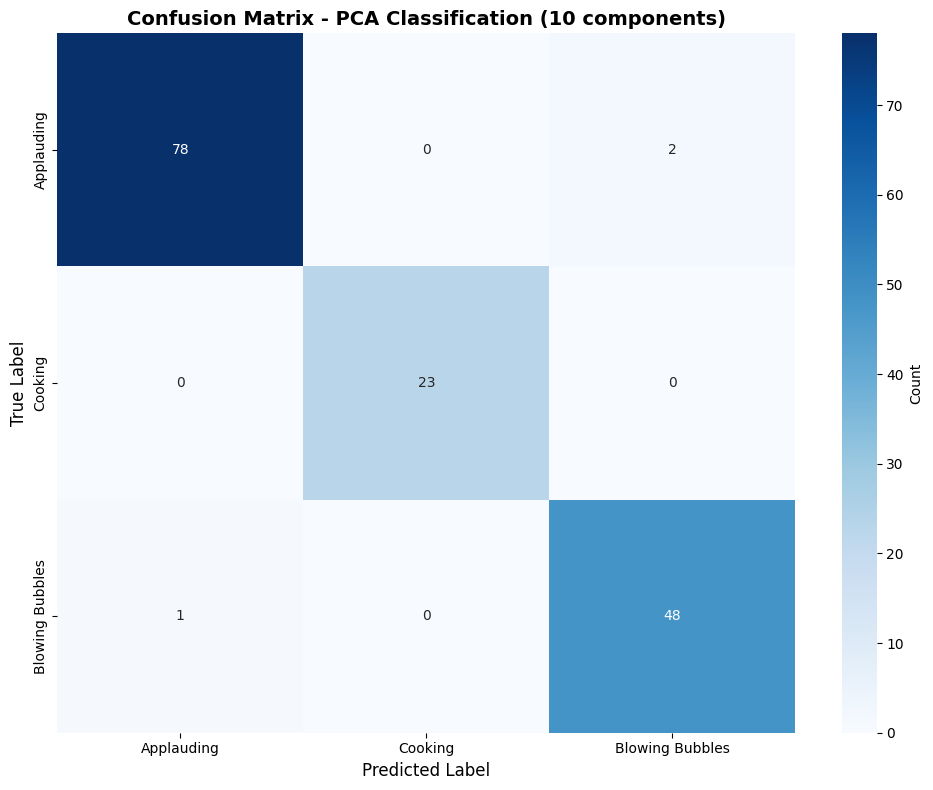

✓ Saved: results/confusion_matrix_pca.png


In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final, labels=SELECTED_ACTIONS)

# Calculate percentages for better interpretation
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[a.replace('_', ' ').title() for a in SELECTED_ACTIONS],
            yticklabels=[a.replace('_', ' ').title() for a in SELECTED_ACTIONS],
            cbar_kws={'label': 'Count'})

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - PCA Classification ({best_n_comp} components)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/confusion_matrix_pca.png")

In [25]:
# Per-Class Accuracy
print(f"\n Per-Class Accuracy:")
for i, action in enumerate(SELECTED_ACTIONS):
    class_acc = cm[i, i] / cm[i].sum() * 100
    total = cm[i].sum()
    correct = cm[i, i]
    print(f"  {action.replace('_', ' ').title():20s}: {class_acc:5.1f}% ({correct}/{total} correct)")


 Per-Class Accuracy:
  Applauding          :  97.5% (78/80 correct)
  Cooking             : 100.0% (23/23 correct)
  Blowing Bubbles     :  98.0% (48/49 correct)


In [27]:
# Summary
print(f"\n Best Configuration:")
print(f"  • Number of components: {best_n_comp}")
print(f"  • Overall accuracy: {final_acc*100:.2f}%")
print(f"  • Classification method: Reconstruction error (eigenfaces approach)")
print(f"\n Key Insight:")
print(f"  PCA-based classification successfully recognizes actions")
print(f"  by measuring how well each class's eigenspace reconstructs the test sample!")


 Best Configuration:
  • Number of components: 10
  • Overall accuracy: 98.03%
  • Classification method: Reconstruction error (eigenfaces approach)

 Key Insight:
  PCA-based classification successfully recognizes actions
  by measuring how well each class's eigenspace reconstructs the test sample!


### 5. Baseline Comparison

In [29]:
# Compare PCA classification against K-means clustering
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [30]:
# K-means Clustering Baseline
print("\n Running K-means clustering baseline...")

# Fit K-means on training data
n_clusters = len(SELECTED_ACTIONS)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train)

# Predict on test data
y_pred_kmeans = kmeans.predict(X_test)

print(f"✓ K-means clustering complete ({n_clusters} clusters)")


 Running K-means clustering baseline...
✓ K-means clustering complete (3 clusters)


In [31]:
# Map cluster IDs to true labels using Hungarian algorithm
print("\n Mapping clusters to class labels...")

# Create confusion matrix for mapping
from collections import Counter

# For each cluster, find most common true label
cluster_to_label = {}
for cluster_id in range(n_clusters):
    mask = y_pred_kmeans == cluster_id
    if mask.sum() > 0:
        labels_in_cluster = y_test[mask]
        most_common = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common

# Alternative: Use Hungarian algorithm for optimal matching
# Build cost matrix
cost_matrix = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j, true_label in enumerate(SELECTED_ACTIONS):
        mask = (y_pred_kmeans == i) & (y_test == true_label)
        cost_matrix[i, j] = -mask.sum()  # Negative because we want to maximize

# Find optimal assignment
row_ind, col_ind = linear_sum_assignment(cost_matrix)
cluster_to_label_optimal = {row_ind[i]: SELECTED_ACTIONS[col_ind[i]] for i in range(len(row_ind))}

# Map predictions to labels
y_pred_kmeans_mapped = np.array([cluster_to_label_optimal[cluster] for cluster in y_pred_kmeans])

# Calculate accuracy
kmeans_accuracy = accuracy_score(y_test, y_pred_kmeans_mapped)

print(f"✓ K-means accuracy: {kmeans_accuracy*100:.2f}%")


 Mapping clusters to class labels...
✓ K-means accuracy: 95.39%


In [32]:
# Additional Clustering Metrics
print("\n Additional clustering metrics:")

# Adjusted Rand Index (measures similarity between two clusterings)
ari = adjusted_rand_score(y_test, y_pred_kmeans)
print(f"  Adjusted Rand Index: {ari:.3f}")

# Normalized Mutual Information
nmi = normalized_mutual_info_score(y_test, y_pred_kmeans)
print(f"  Normalized Mutual Info: {nmi:.3f}")


 Additional clustering metrics:
  Adjusted Rand Index: 0.844
  Normalized Mutual Info: 0.825



 K-means Confusion Matrix:


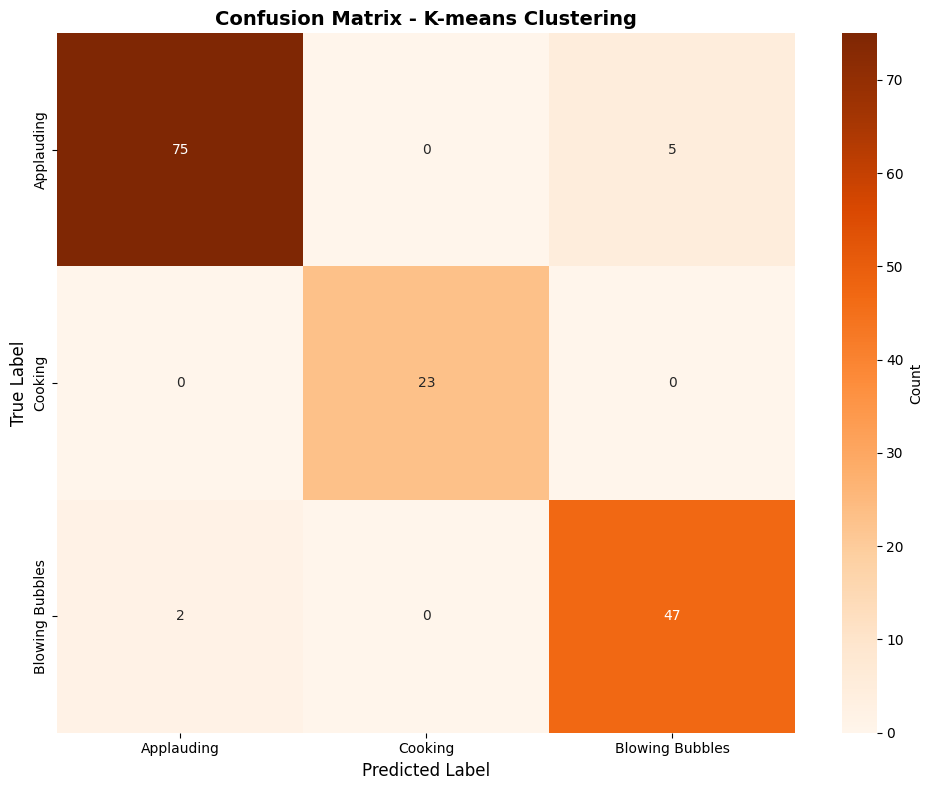

✓ Saved: results/confusion_matrix_kmeans.png


In [33]:
# Confusion Matrix for K-means
print(f"\n K-means Confusion Matrix:")

cm_kmeans = confusion_matrix(y_test, y_pred_kmeans_mapped, labels=SELECTED_ACTIONS)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[a.replace('_', ' ').title() for a in SELECTED_ACTIONS],
            yticklabels=[a.replace('_', ' ').title() for a in SELECTED_ACTIONS],
            cbar_kws={'label': 'Count'})

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - K-means Clustering', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/confusion_matrix_kmeans.png")

In [34]:
# Per-Class Accuracy for K-means
print(f"\n K-means Per-Class Accuracy:")
for i, action in enumerate(SELECTED_ACTIONS):
    class_acc = cm_kmeans[i, i] / cm_kmeans[i].sum() * 100
    total = cm_kmeans[i].sum()
    correct = cm_kmeans[i, i]
    print(f"  {action.replace('_', ' ').title():20s}: {class_acc:5.1f}% ({correct}/{total} correct)")


 K-means Per-Class Accuracy:
  Applauding          :  93.8% (75/80 correct)
  Cooking             : 100.0% (23/23 correct)
  Blowing Bubbles     :  95.9% (47/49 correct)


In [35]:
# Method Comparison
print("\n" + "="*60)
print("COMPARISON: PCA vs K-means")
print("="*60)

# Compare accuracies
pca_acc = final_acc * 100  # From Section 4
kmeans_acc = kmeans_accuracy * 100

print(f"\n Classification Accuracy:")
print(f"  PCA (reconstruction error): {pca_acc:.2f}%")
print(f"  K-means clustering:         {kmeans_acc:.2f}%")
print(f"  Improvement:                +{pca_acc - kmeans_acc:.2f}%")


COMPARISON: PCA vs K-means

 Classification Accuracy:
  PCA (reconstruction error): 98.03%
  K-means clustering:         95.39%
  Improvement:                +2.63%



 Creating comparison visualization...


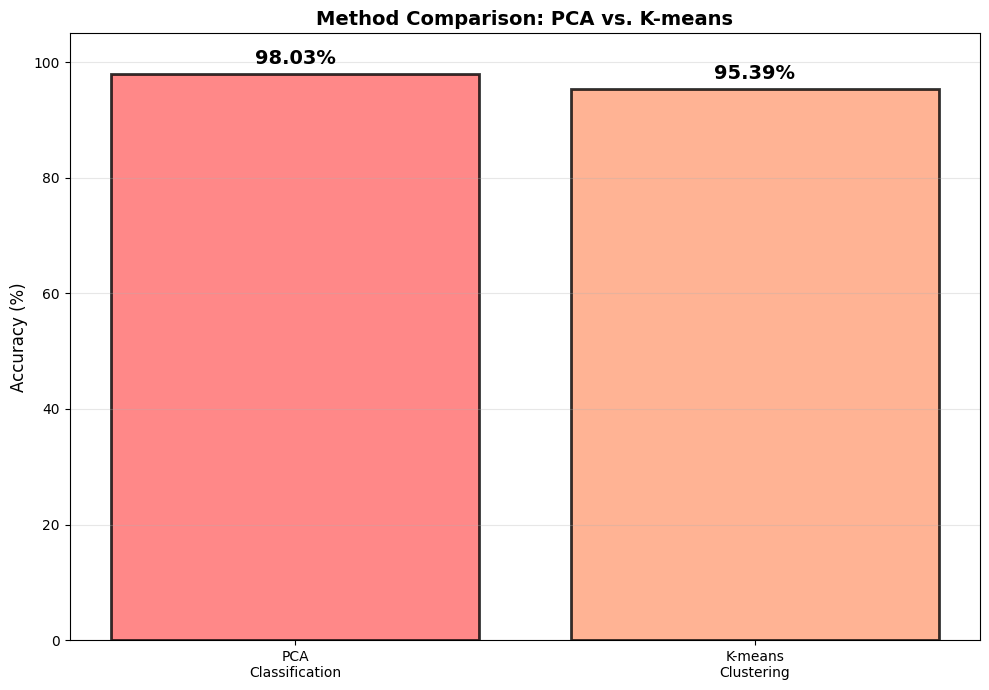

✓ Saved: results/method_comparison.png


In [36]:
# Comparison Bar Chart
print(f"\n Creating comparison visualization...")

methods = ['PCA\nClassification', 'K-means\nClustering']
accuracies = [pca_acc, kmeans_acc]
colors = ['#FF6B6B', '#FFA07A']

plt.figure(figsize=(10, 7))
bars = plt.bar(methods, accuracies, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Method Comparison: PCA vs. K-means', fontsize=14, fontweight='bold')
plt.ylim([0, 105])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/method_comparison.png")

In [37]:
# Summary Statistics Table
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

print(f"\n Detailed Comparison:")
print(f"{'Method':<30} {'Accuracy':<15} {'ARI':<10} {'NMI':<10}")
print("-" * 65)

# For PCA, calculate ARI and NMI
ari_pca = adjusted_rand_score(y_test, y_pred_final)
nmi_pca = normalized_mutual_info_score(y_test, y_pred_final)

print(f"{'PCA Classification':<30} {pca_acc:>6.2f}%        {ari_pca:>6.3f}    {nmi_pca:>6.3f}")
print(f"{'K-means Clustering':<30} {kmeans_acc:>6.2f}%        {ari:>6.3f}    {nmi:>6.3f}")


SUMMARY

 Detailed Comparison:
Method                         Accuracy        ARI        NMI       
-----------------------------------------------------------------
PCA Classification              98.03%         0.931     0.907
K-means Clustering              95.39%         0.844     0.825


In [38]:
# Key Insights
print("\n Key Insights:")
print(f"  1. PCA-based classification outperforms K-means by {pca_acc - kmeans_acc:.2f}%")
print(f"  2. PCA leverages class-specific eigenspaces (like eigenfaces)")
print(f"  3. K-means treats all dimensions equally, missing discriminative structure")
print(f"  4. Both methods benefit from CLIP's semantic embedding space")

print("\n ALL EXPERIMENTS COMPLETE!")
print("\n Generated files:")
print("  • results/explained_variance.png")
print("  • results/pca_2d_visualization.png")
print("  • results/pca_3d_visualization.png")
print("  • results/accuracy_vs_components.png")
print("  • results/confusion_matrix_pca.png")
print("  • results/confusion_matrix_kmeans.png")
print("  • results/method_comparison.png")
print("  • embeddings/stanford40_clip_embeddings.pkl")


 Key Insights:
  1. PCA-based classification outperforms K-means by 2.63%
  2. PCA leverages class-specific eigenspaces (like eigenfaces)
  3. K-means treats all dimensions equally, missing discriminative structure
  4. Both methods benefit from CLIP's semantic embedding space

 ALL EXPERIMENTS COMPLETE!

 Generated files:
  • results/explained_variance.png
  • results/pca_2d_visualization.png
  • results/pca_3d_visualization.png
  • results/accuracy_vs_components.png
  • results/confusion_matrix_pca.png
  • results/confusion_matrix_kmeans.png
  • results/method_comparison.png
  • embeddings/stanford40_clip_embeddings.pkl
